# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import sys
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

In [5]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU for you...")

2024-01-31 06:29:22.566112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 06:29:22.566146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 06:29:22.567246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 06:29:22.573388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 06:29:23.375981: W tensorflow/comp

We got a GPU


# Label Data

In [6]:
repo_fp = Path('./')
processed_img_fp = repo_fp / 'processed_img'
processed_img_fp.exists()

True

## Image Data

In [7]:
img_label_df = repo_fp / 'image_dataset_v2.csv'
img_label_df = pd.read_csv(img_label_df, index_col=0)
img_label_df

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path
0,TAN,TAN045,TAN_TAN045,1,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,1672994795748.jpg,./processed_img/TAN_TAN045/1672994795748.jpg
1,TAN,TAN045,TAN_TAN045,1,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,1672994795743.jpg,./processed_img/TAN_TAN045/1672994795743.jpg
2,TAN,TAN045,TAN_TAN045,1,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,1672994795718.jpg,./processed_img/TAN_TAN045/1672994795718.jpg
3,TAN,TAN045,TAN_TAN045,1,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,1672994795729.jpg,./processed_img/TAN_TAN045/1672994795729.jpg
4,TAN,TAN045,TAN_TAN045,1,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,1672994795723.jpg,./processed_img/TAN_TAN045/1672994795723.jpg
...,...,...,...,...,...,...,...,...
3350,TAN,TAN014,TAN_TAN014,1,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_221006113544221.jpg,./processed_img/TAN_TAN014/IMG_221006113544221...
3351,TAN,TAN014,TAN_TAN014,1,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_221006113944682.jpg,./processed_img/TAN_TAN014/IMG_221006113944682...
3352,TAN,TAN014,TAN_TAN014,1,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_221006113632001.jpg,./processed_img/TAN_TAN014/IMG_221006113632001...
3353,TAN,TAN014,TAN_TAN014,1,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_221006113754747.jpg,./processed_img/TAN_TAN014/IMG_221006113754747...


## Patient Data

In [8]:
patient_ds = pd.read_csv(repo_fp / 'patient_dataset.csv', index_col=0)
patient_ds

,data,patient_id,img_id,label,dataset
0,TAN,TAN045,TAN_TAN045,1,train
1,NOH,122,NOH_122,4,train
2,NOH,103,NOH_103,4,train
3,TAN,TAN079,TAN_TAN079,1,train
4,NOH,31,NOH_31,0,train
...,...,...,...,...,...
232,TAN,TAN102,TAN_TAN102,1,test
233,TAN,TAN078,TAN_TAN078,1,test
234,TAN,TAN086,TAN_TAN086,1,test
235,NOH,24,NOH_24,5,test


data
NOH    2048
TAN    1307
Name: count, dtype: int64
data
NOH    132
TAN    105
Name: count, dtype: int64


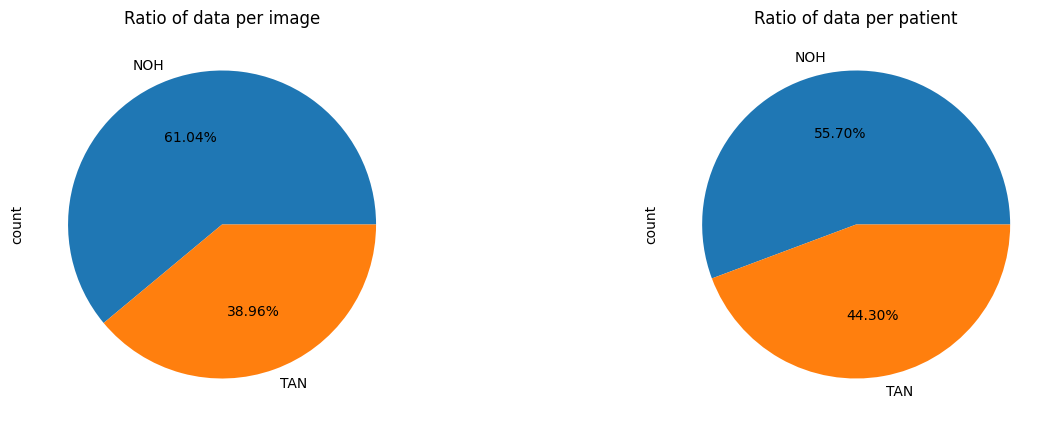

In [9]:
tmp = img_label_df['data'].value_counts()
tmp1 = img_label_df[['data', 'patient_id']].drop_duplicates()['data'].value_counts()

print(tmp)
print(tmp1)
fig, axs = plt.subplots(1,2, figsize=(15,5))
tmp.plot(kind='pie', autopct='%.2f%%', ax=axs[0])
axs[0].set_title('Ratio of data per image')
tmp1.plot(kind='pie', autopct='%.2f%%', ax=axs[1])
axs[1].set_title('Ratio of data per patient')
plt.show()

## Stats dataset per patient

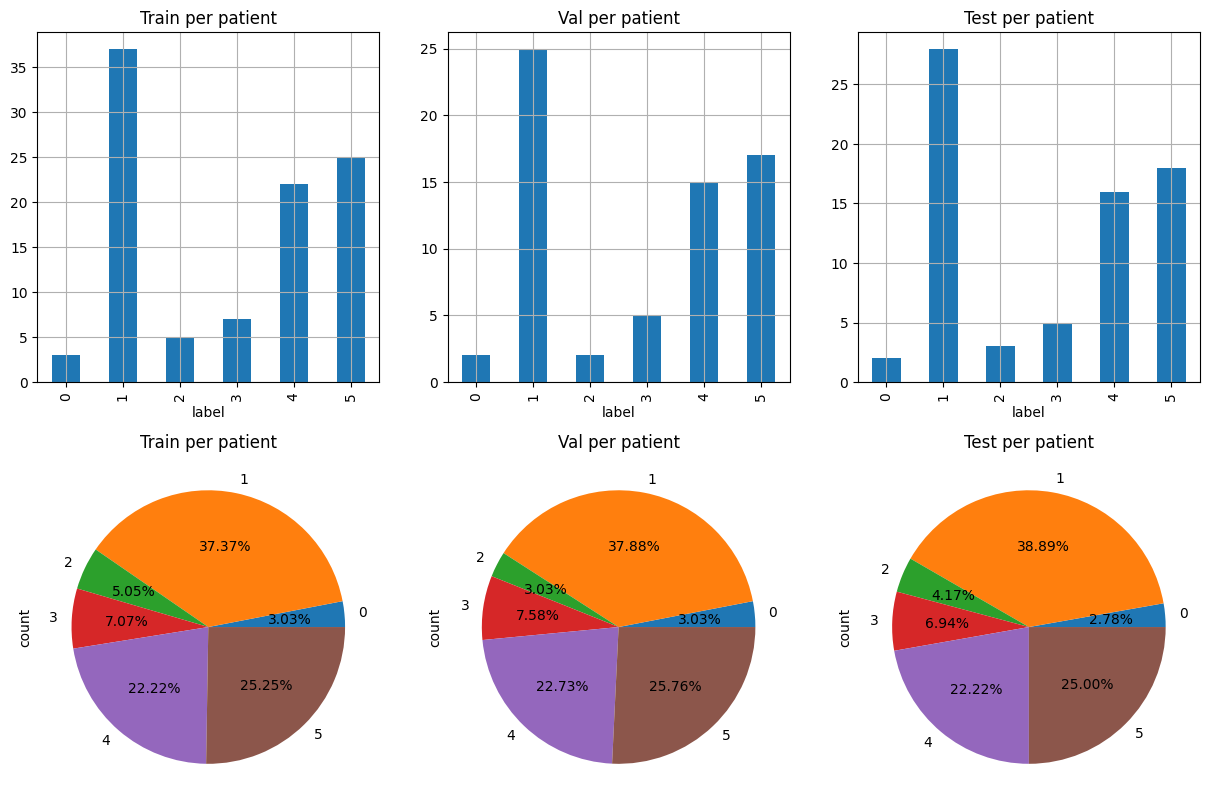

In [10]:
train_patient_label = patient_ds[patient_ds['dataset']=='train']['label'].value_counts().sort_index()
val_patient_label = patient_ds[patient_ds['dataset']=='val']['label'].value_counts().sort_index()
test_patient_label = patient_ds[patient_ds['dataset']=='test']['label'].value_counts().sort_index()

fig, axs = plt.subplots(2,3, figsize=(15,10))
train_patient_label.plot(kind='bar', ax=axs[0][0], title='Train per patient',grid=True)
val_patient_label.plot(kind='bar', ax=axs[0][1],title='Val per patient',grid=True)
test_patient_label.plot(kind='bar', ax=axs[0][2], title='Test per patient',grid=True)
train_patient_label.plot(kind='pie', ax=axs[1][0], title='Train per patient', autopct='%.2f%%')
val_patient_label.plot(kind='pie', ax=axs[1][1],title='Val per patient', autopct='%.2f%%')
test_patient_label.plot(kind='pie', ax=axs[1][2], title='Test per patient', autopct='%.2f%%')
plt.show()

## Stats dataset per image

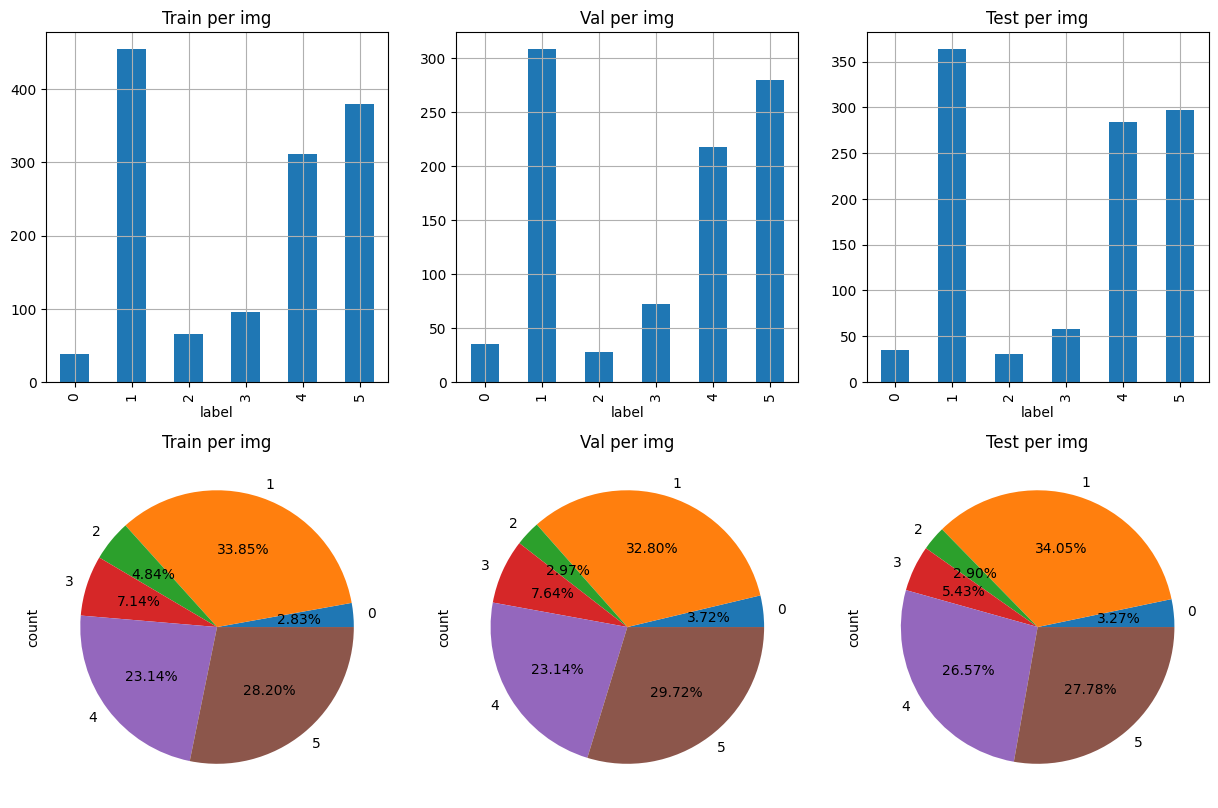

In [11]:
train_patient_label = img_label_df[img_label_df['dataset']=='train']['label'].value_counts().sort_index()
val_patient_label = img_label_df[img_label_df['dataset']=='val']['label'].value_counts().sort_index()
test_patient_label = img_label_df[img_label_df['dataset']=='test']['label'].value_counts().sort_index()

fig, axs = plt.subplots(2,3, figsize=(15,10))
train_patient_label.plot(kind='bar', ax=axs[0][0], title='Train per img', grid=True)
val_patient_label.plot(kind='bar', ax=axs[0][1],title='Val per img', grid=True)
test_patient_label.plot(kind='bar', ax=axs[0][2], title='Test per img', grid=True)
train_patient_label.plot(kind='pie', ax=axs[1][0], title='Train per img', autopct='%.2f%%')
val_patient_label.plot(kind='pie', ax=axs[1][1],title='Val per img', autopct='%.2f%%')
test_patient_label.plot(kind='pie', ax=axs[1][2], title='Test per img', autopct='%.2f%%')
plt.show()

In [12]:
# check dataset per image
img_label_df.groupby('dataset')['label'].value_counts().to_frame('count').reset_index().pivot_table(index='dataset', columns='label', values='count').fillna(0).astype(int)

label,0,1,2,3,4,5
dataset,,,,,,
test,35,364,31,58,284,297
train,38,455,65,96,311,379
val,35,309,28,72,218,280


## Transform

### Test transform

In [13]:
plt.rcParams["savefig.bbox"] = 'tight'

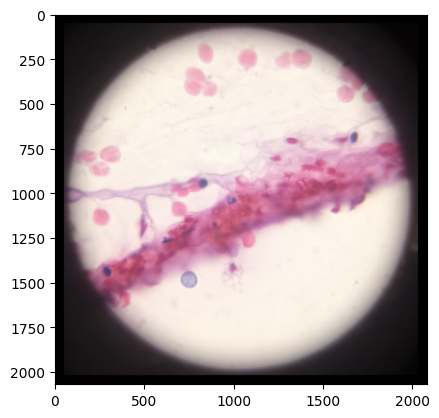

In [14]:
img_path = img_label_df.iloc[0]['new_img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [15]:
# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.RandomPerspective(distortion_scale=0.3, p=0.2),
    v2.ColorJitter(brightness=.5, hue=.3),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomPosterize(bits=2),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

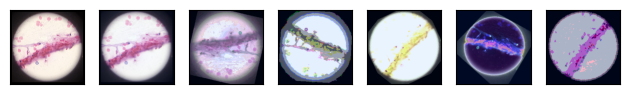

In [16]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [17]:
batch_size=32

# Dataset and DataLoader

In [18]:
# prompt: i need pytorch dataset that read from dataframe
class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['new_img_path'][idx]
        label = self.dataframe['label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [19]:
train_df = img_label_df[img_label_df['dataset']=='train'].reset_index(drop=True)
val_df = img_label_df[img_label_df['dataset']=='val'].reset_index(drop=True)
test_df = img_label_df[img_label_df['dataset']=='test'].reset_index(drop=True)

In [20]:
trainset = ThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

In [21]:
valset = ThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=16)

In [22]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=16)

##  Inspect Image

In [23]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

./processed_img/NOH_9/IMG_20221227_144909.jpg


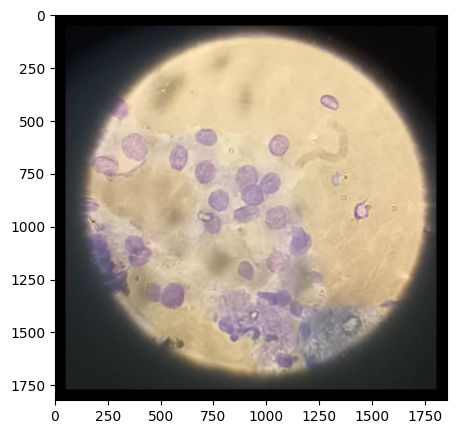

In [24]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['new_img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

## Try load a batch

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


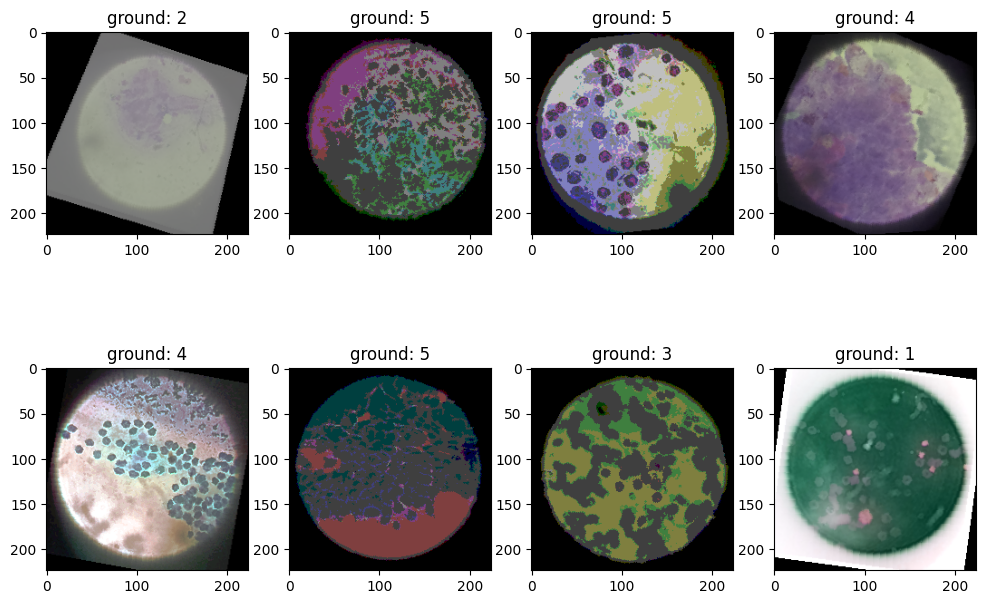

In [25]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/thyroid_classification')

# Load model

In [28]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(1280, train_df['label'].nunique())
model.to(device);

Loaded pretrained weights for efficientnet-b0


In [29]:
num_epochs = 300
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=4, verbose=True)

In [31]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0005, total_steps=num_epochs*len(trainloader))

In [32]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    f1 = 0.0
    auc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        # f1 += f1_score(output.argmax(dim=1), target)
        # auc += roc_auc_score(target, output[:, 1])
    loss /= len(testloader)
    acc /= len(testloader)
    # f1 /= len(testloader)
    # auc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    return acc

## If exist model, then evaluate before write new

In [33]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Test Loss: 0.0357 	Test Acc: 0.4995
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label:  5
Predicted:  4
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  1
Label:  5
Predicted:  5
Label:  5
Predicted:  4
Label:  5
Predicted:  4


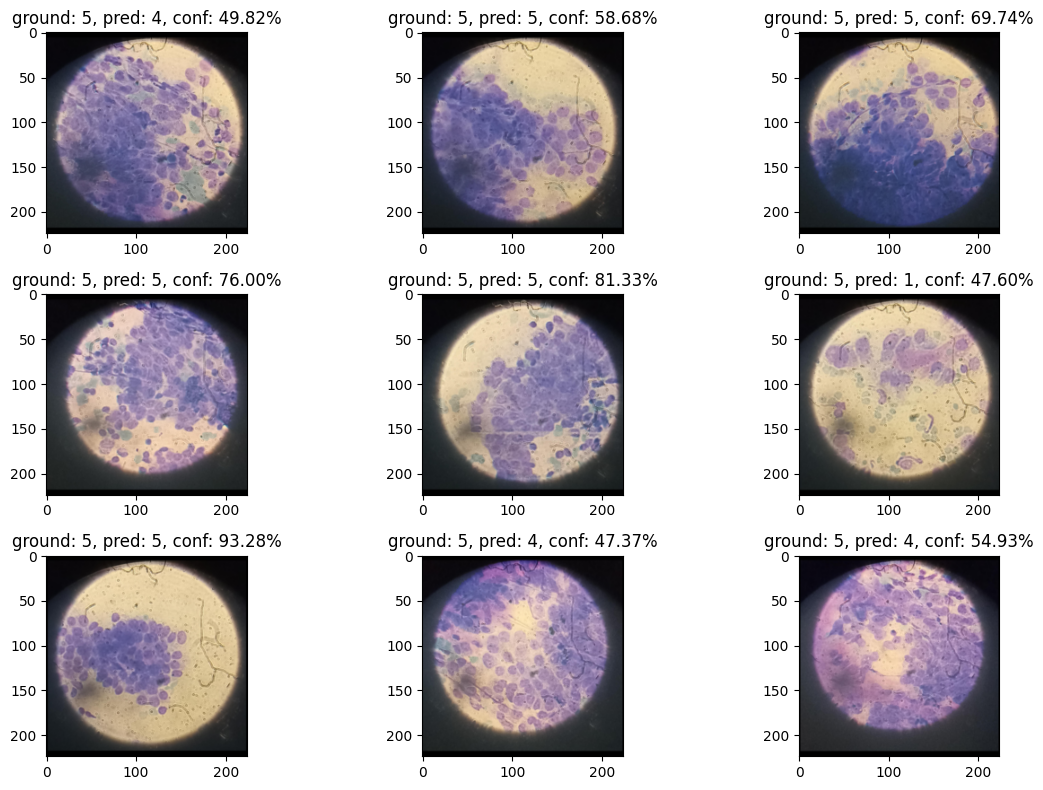

In [34]:
# reload model
model_fp = repo_fp / 'efficientnet-b0-classification.pt'
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)
    run_predict_testset()

In [35]:
best_val_acc

0.4994747899159664

## Try load all batches (if any errors)

In [36]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [37]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [38]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

# Train model

In [39]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Train
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_progress_bar = tqdm(total=len(trainloader), desc="Train")
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())

        train_progress_bar.set_postfix(
            accuracy=train_acc / len(trainloader),
            loss=loss.item(),
            avg_loss=train_loss/len(trainloader),
            # lr=scheduler.get_last_lr()[0]
            )
        train_progress_bar.update()

    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    train_progress_bar.close()

    # Eval
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_progress_bar = tqdm(total=len(valoader), desc="Val")
    for batch_idx, (data, target) in enumerate(valoader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())

        val_progress_bar.set_postfix(
            accuracy=val_acc / len(valoader),
            loss=loss.item(),
            avg_loss=val_loss/len(valoader))
        val_progress_bar.update()
    val_loss /= len(valoader)
    val_acc /= len(valoader)
    val_progress_bar.close()

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'efficientnet-b0-classification.pt')

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.9380 	Train Acc: 0.6220 	Val Loss: 1.5155 	Val Acc: 0.5604


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.9097 	Train Acc: 0.6481 	Val Loss: 1.5126 	Val Acc: 0.5615


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.8822 	Train Acc: 0.6600 	Val Loss: 1.5023 	Val Acc: 0.5442


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.8794 	Train Acc: 0.6473 	Val Loss: 1.4743 	Val Acc: 0.5213


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.8699 	Train Acc: 0.6488 	Val Loss: 1.4754 	Val Acc: 0.5098


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.8655 	Train Acc: 0.6629 	Val Loss: 1.4470 	Val Acc: 0.5106


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: nan 	Train Acc: 0.0283 	Val Loss: nan 	Val Acc: 0.0418


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7 	Train Loss: nan 	Train Acc: 0.0283 	Val Loss: nan 	Val Acc: 0.0418


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: nan 	Train Acc: 0.0283 	Val Loss: nan 	Val Acc: 0.0418


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9 	Train Loss: nan 	Train Acc: 0.0283 	Val Loss: nan 	Val Acc: 0.0418


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
best_val_acc

# Evaluate testset

In [ ]:
evaluate_dataset(model, testloader)